In [1]:
#The ingest function uses an annotated datasets and fits a model on this data. It then uses it to project new data
#Is there an example of when we would need to apply the details of one dataset to another?

In [2]:
#We refer to this asymmetric dataset integration as ingesting annotations from an annotated reference adata_ref into an adata that still lacks this annotatio

In [3]:
import scanpy as sc
import pandas as pd
import seaborn as sns

sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

-----
anndata     0.8.0
scanpy      1.9.2
-----
PIL                         9.0.1
appnope                     0.1.2
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.4
cffi                        1.15.0
cloudpickle                 2.0.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.02.1
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fsspec                      2022.02.0
google                      NA
h5py                        3.6.0
igraph                      0.10.2
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
jinja2                      2.11.3
j

In [4]:
#  annotated reference dataset = adata_ref,  dataset for which you want to query labels and embeddings = adata

In [5]:
adata_ref = sc.datasets.pbmc3k_processed()  # this is an earlier version of the dataset from the pbmc3k tutorial
adata = sc.datasets.pbmc68k_reduced()

In [6]:
#Defining datasets on same variables
var_names = adata_ref.var_names.intersection(adata.var_names)
#making sure it only contains the same variables:
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]
adata_ref.uns

OverloadedDict, wrapping:
	{'draw_graph': {'params': {'layout': 'fr', 'random_state': array([0])}}, 'louvain': {'params': {'random_state': array([0]), 'resolution': array([1])}}, 'louvain_colors': array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2', '#bcbd22'], dtype='<U7'), 'neighbors': {'params': {'method': 'umap', 'n_neighbors': array([10])}}, 'pca': {'variance': array([32.11044  , 18.718647 , 15.607319 , 13.235274 ,  4.8012376,
        3.977329 ,  3.5053132,  3.1576602,  3.028463 ,  2.9777625,
        2.8842385,  2.8583548,  2.849085 ,  2.8220255,  2.811057 ,
        2.781576 ,  2.7436602,  2.7404478,  2.736062 ,  2.6872916,
        2.671316 ,  2.6690092,  2.6442325,  2.6394093,  2.6157827,
        2.6102393,  2.575101 ,  2.5691617,  2.563295 ,  2.5489197,
        2.5080354,  2.4762378,  2.264355 ,  2.1844513,  2.1353922,
        2.096509 ,  2.0606086,  2.0105643,  1.9703175,  1.9465197,
        1.9220033,  1.8847997,  1.8349565,  1.8038161,  1

In [7]:
#Why do you have to run pca first?
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

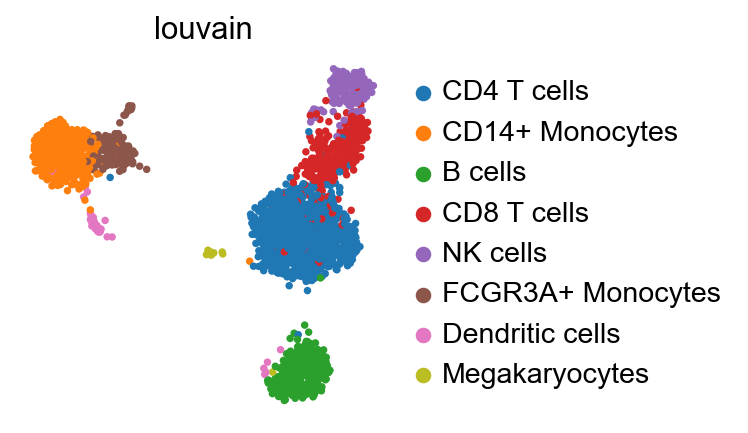

In [8]:
sc.pl.umap(adata_ref, color = 'louvain')

In [9]:
#Mapping PBMCs (peripheral blood mononuclear cell) using ingest
sc.tl.ingest(adata, adata_ref, obs='louvain')
#For ingest you have to list original and new dataset
#how do you know what obs to use? later example uses cell_types

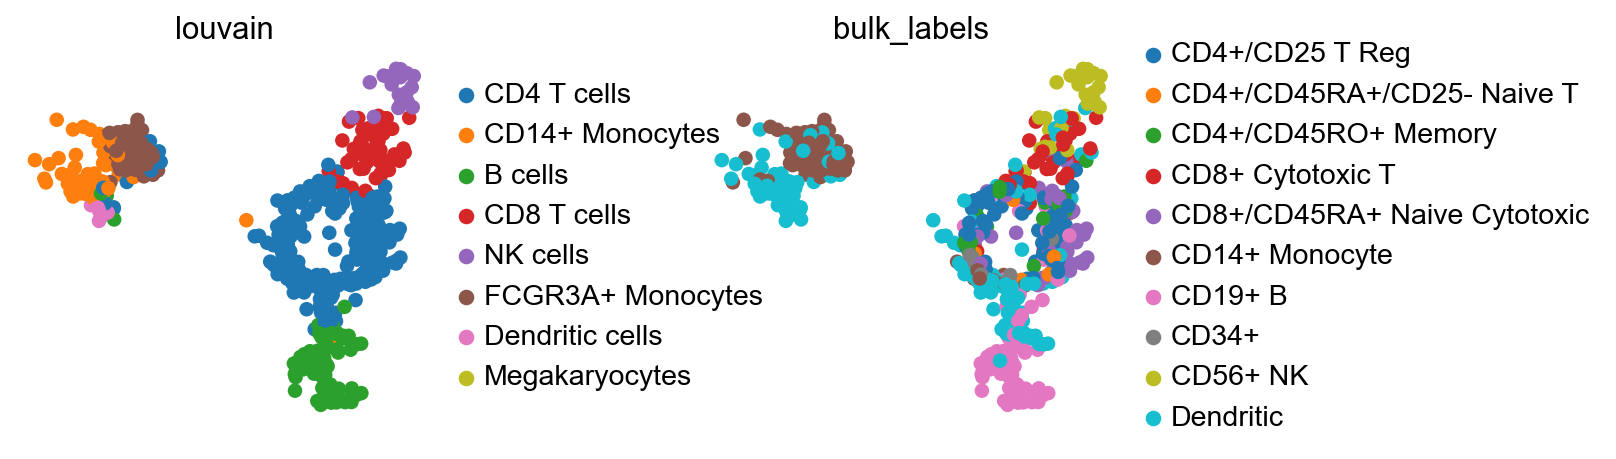

In [10]:
adata.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix colors
sc.pl.umap(adata, color=['louvain', 'bulk_labels'], wspace=0.5)

/Users/vishruthdinesh/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/var/folders/fk/b48hvk411s3c4msry_1w3x1h0000gn/T/ipykernel_23052/416647803.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering


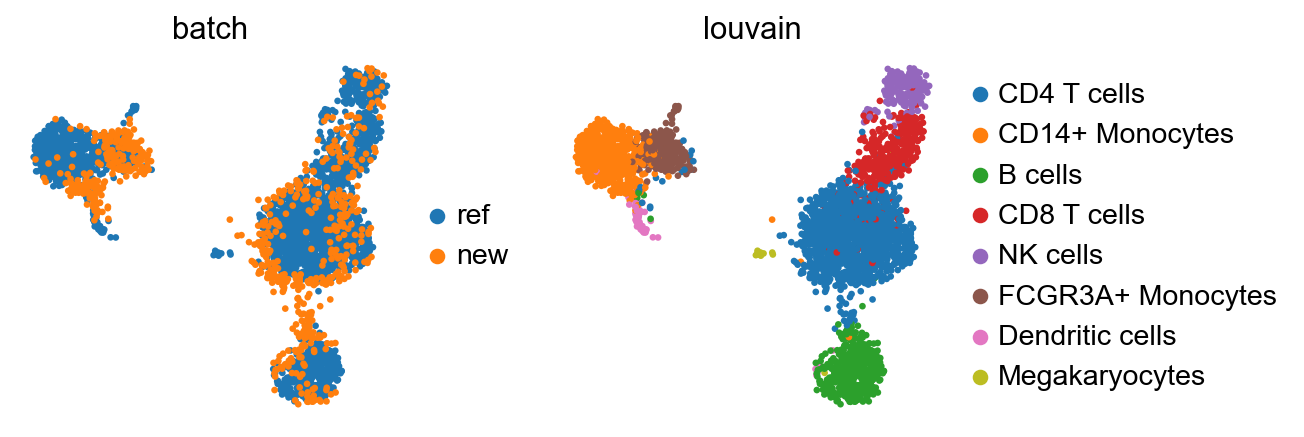

In [11]:
adata_concat = adata_ref.concatenate(adata, batch_categories=['ref', 'new'])
adata_concat.obs.louvain = adata_concat.obs.louvain.astype('category')
adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix category colors
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

In [12]:
#The 'batch' color shows how well the old data maps onto the new one. New data points. Is there a better explanation?


In [13]:
pip install bbknn

Note: you may need to restart the kernel to use updated packages.


In [14]:
#USING BBKNN

sc.tl.pca(adata_concat)
sc.external.pp.bbknn(adata_concat, batch_key = 'batch')

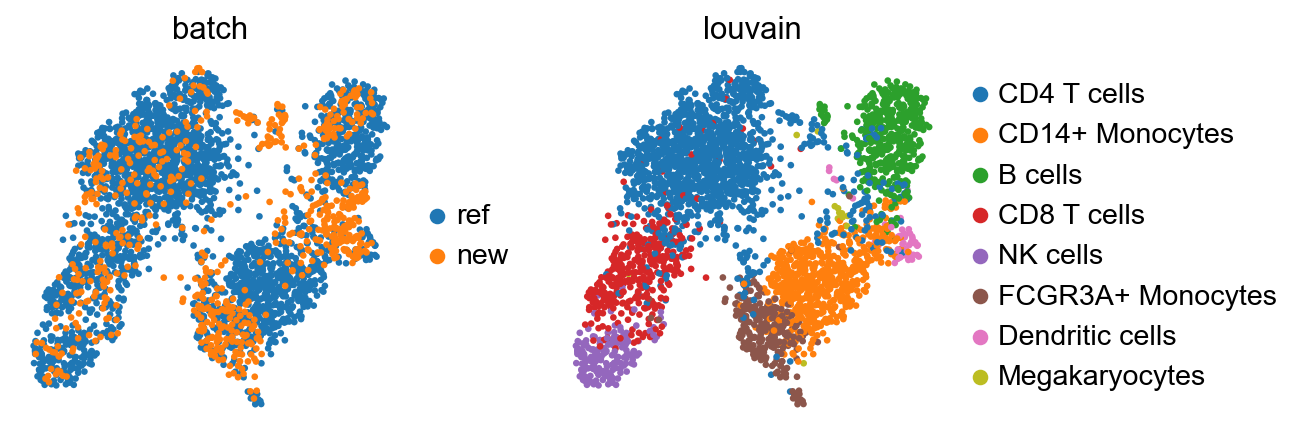

In [15]:
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=['batch', 'louvain'])


In [16]:
#Why are the results so different

# Pancreas

In [17]:
adata_all = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')

/Users/vishruthdinesh/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/vishruthdinesh/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [36]:
adata_all.shape
adata.count.celltype

AttributeError: 'AnnData' object has no attribute 'count'

In [19]:
counts = adata_all.obs.celltype.value_counts()
counts
adata_all.shape

(14693, 2448)

In [20]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

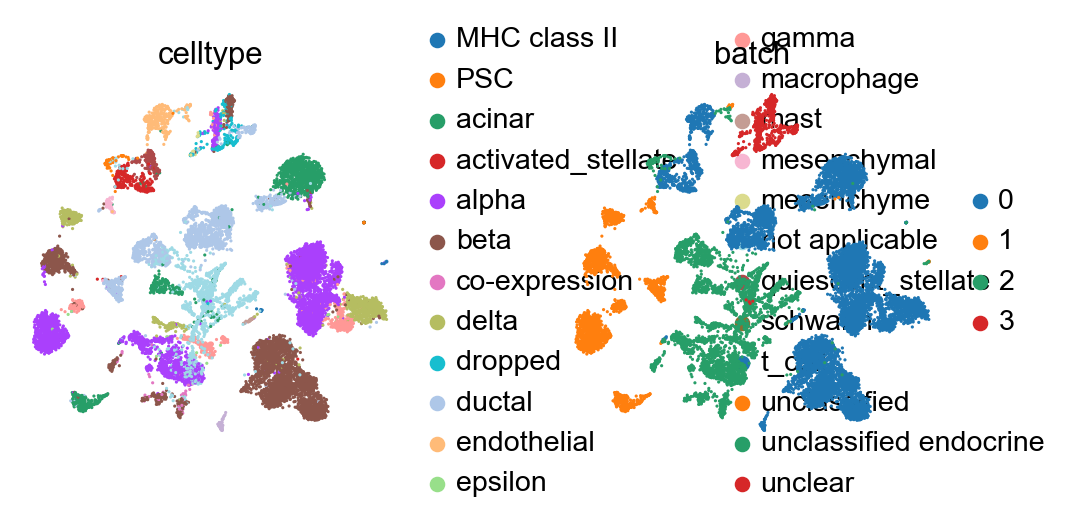

In [21]:
sc.pl.umap(adata_all, color = ['celltype', 'batch'], palette=sc.pl.palettes.vega_20_scanpy)

In [22]:
%%time
sc.external.pp.bbknn(adata_all, batch_key='batch')

CPU times: user 1.37 s, sys: 10.9 ms, total: 1.38 s
Wall time: 1.26 s


In [27]:
adata_ref = adata_all[adata_all.obs.batch == '0']
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)


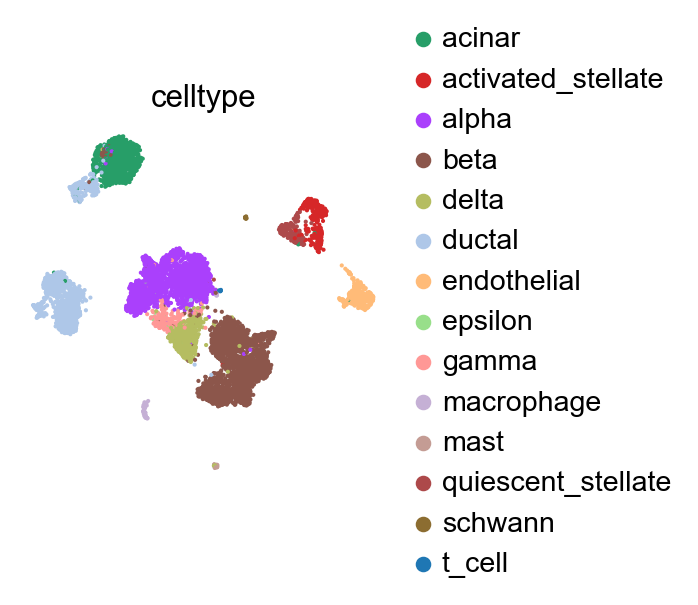

In [31]:
sc.pl.umap(adata_ref, color = ['celltype'])

In [32]:
adatas = [adata_all[adata_all.obs.batch == i].copy() for i in ['1', '2', '3']]

In [33]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f'... integrating batch {iadata+1}')
    adata.obs['celltype_orig'] = adata.obs.celltype  # save the original cell type
    sc.tl.ingest(adata, adata_ref, obs='celltype')
#Combining two datasets

... integrating batch 1
running ingest
    finished (0:00:03)
... integrating batch 2
running ingest
    finished (0:00:05)
... integrating batch 3
running ingest
    finished (0:00:01)


/Users/vishruthdinesh/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/var/folders/fk/b48hvk411s3c4msry_1w3x1h0000gn/T/ipykernel_23052/2105685923.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories, inplace=True)  # fix category ordering


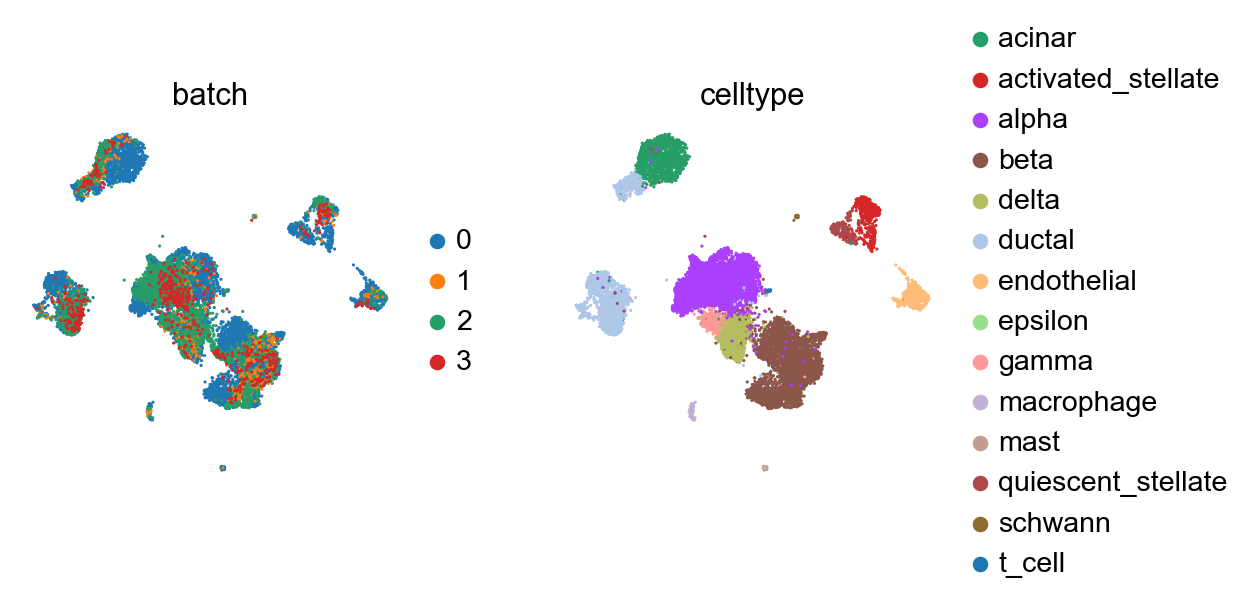

In [34]:
adata_concat = adata_ref.concatenate(adatas)

adata_concat.obs.celltype = adata_concat.obs.celltype.astype('category')
adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['celltype_colors'] = adata_ref.uns['celltype_colors']  # fix category coloring

sc.pl.umap(adata_concat, color=['batch', 'celltype'])

/Users/vishruthdinesh/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


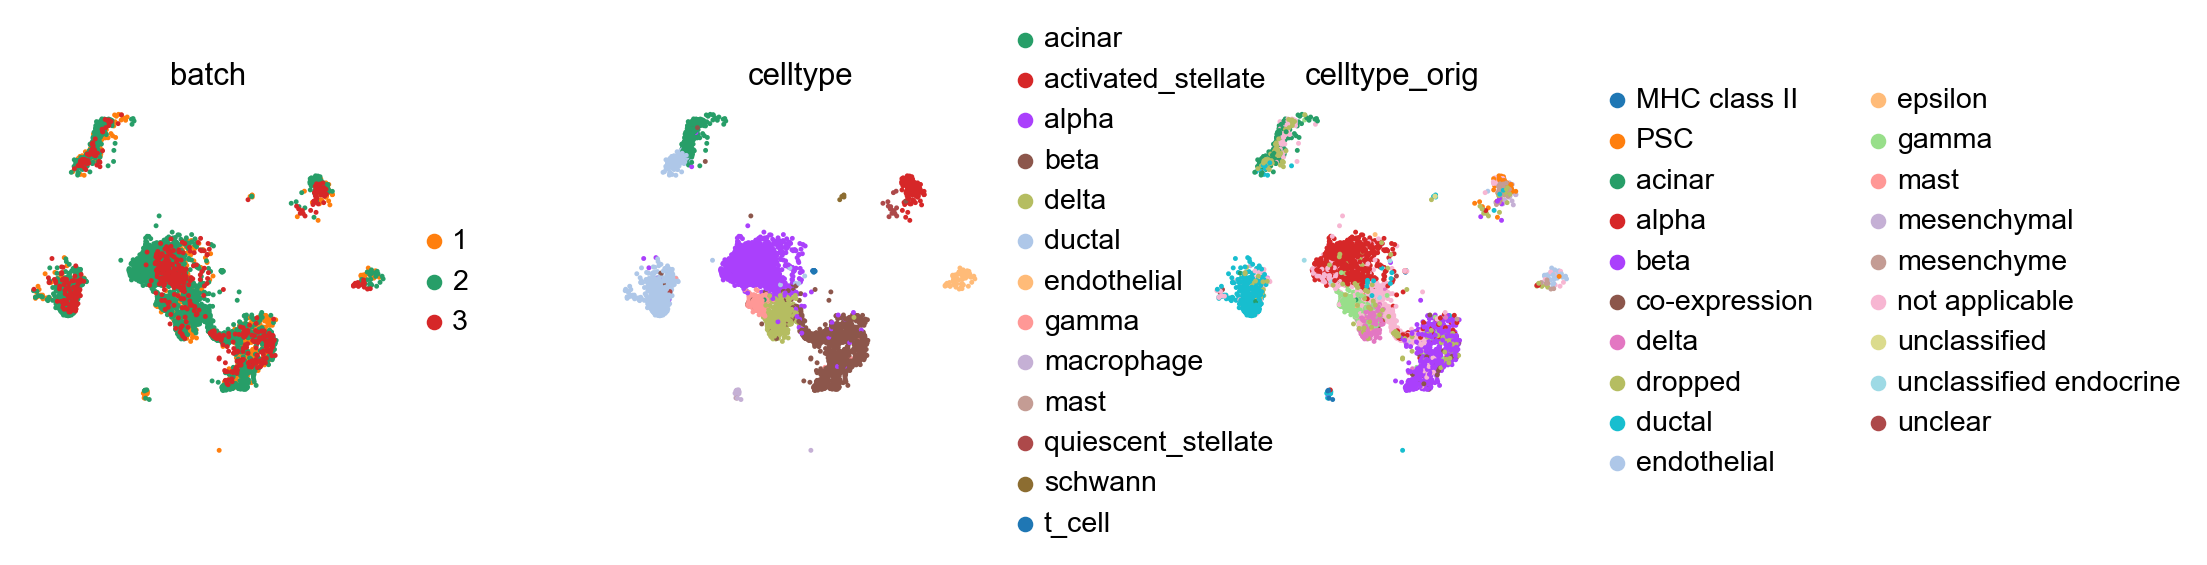

In [37]:
adata_query = adata_concat[adata_concat.obs.batch.isin(['1', '2', '3'])]
sc.pl.umap(
    adata_query, color=['batch', 'celltype', 'celltype_orig'], wspace=0.4)

In [ ]:
#This tutorial was mainly about correcting batch affects, integrating one batch/dataset onto another, and observing differences

In [ ]:
#Didn't udnerstand Cell types conserved across batches